# Loading the dataset

In [ ]:
# Import PyDrive and associated libraries
# This only needs to be done once per notebook
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
# This only needs to be done once per notebook
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Download a file based on its file ID.

# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1izAYScZGiWfis_xXRoGwqgFlhCsPeu5R' # Check your own ID in GDrive
downloaded = drive.CreateFile({'id': file_id})

# Save file in Colab memory
downloaded.GetContentFile('tweet_data.csv')  

# Installing dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_style('dark')
from wordcloud import WordCloud


In [ ]:
df = pd.read_csv('tweet_data.csv', lineterminator='\n')
df = df.drop(['Unnamed: 0'],axis=1)

# Sentiment Analysis using VADER

In [ ]:
# Performing VADER Sentiment Analysis
import nltk
nltk.download('vader_lexicon') # Download the VADER lexicon
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Obtaining NLTK scores
df['VScore'] = df['Clean Text'].apply(lambda x: sia.polarity_scores(x))

# Obtaining NLTK compound score
df['VComp'] = df['VScore'].apply(lambda score_dict: score_dict['compound'])

# Set threshold to define neutral sentiment
neutral_thresh = 0.05

# Categorize scores into the sentiments of positive, neutral or negative
df['Sentiment'] = df['VComp'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
df.head(5)

,Datetime,Text,Username,Like Count,Display Name,Clean Text,VScore,VComp,Sentiment
0,2021-09-01,COVID-19 vaccine required for anyone working a...,tomjgalloway14,10,Tom Galloway,covid19 vaccine required for anyone working at...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1,2021-09-01,"trust me, covid hurt. you won't survive withou...",sh_amx_,0,sham 🇵🇸,trust me covid hurt you will not survive witho...,"{'neg': 0.239, 'neu': 0.43, 'pos': 0.331, 'com...",0.2349,Positive
2,2021-09-01,@SammieJack3 Soros Open Society\nClinton Found...,seve99998,3,seve99999,soros open society\nclinton foundation \ngate...,"{'neg': 0.089, 'neu': 0.911, 'pos': 0.0, 'comp...",-0.6249,Negative
3,2021-09-01,Scotland finally doing QR digital based covid ...,mwhiteside,7,Matthew Whiteside,scotland finally doing qr digital based covid ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
4,2021-09-01,@10DowningStreet \nDear Prime Minister I hope ...,barsh52227438,1,barsh,\ndear prime minister i hope that it is you t...,"{'neg': 0.0, 'neu': 0.786, 'pos': 0.214, 'comp...",0.8437,Positive


(array([     0.,  50000., 100000., 150000., 200000., 250000., 300000.]),
 <a list of 7 Text major ticklabel objects>)

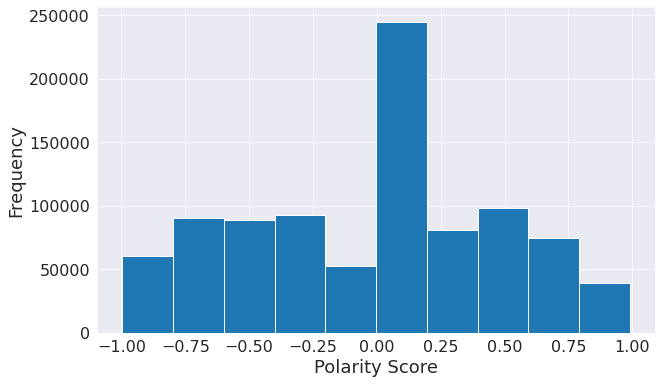

In [ ]:
fig = plt.figure(figsize=(10, 6))
df['VComp'].hist()
plt.xlabel('Polarity Score', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

**Making wordclouds**

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
new_stopwords_to_add = ['covid', 'via', 'v','a','c','c','i','n','e', 'people', 'vaccinated','get','getting','vaccination', 'amp', 'vaccine', 'covid19', 'covidvaccine']
stop_words.extend(new_stopwords_to_add)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


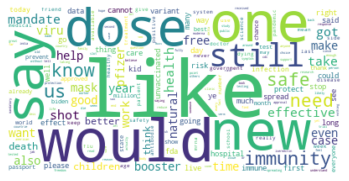

In [ ]:
pos_tweets=df[df["Sentiment"]=="Positive"]
txt=" ".join(tweet for tweet in pos_tweets["Clean Text"])
import re
line = re.sub('vaccine+', "", txt)

wordcloud = WordCloud(collocations = False,
                      background_color = 'white',
                      stopwords=stop_words).generate(line)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

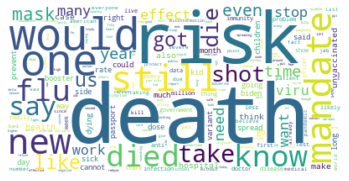

In [ ]:
neg_tweets=df[df["Sentiment"]=="Negative"]
txt=" ".join(tweet.lower() for tweet in neg_tweets["Clean Text"])
line = re.sub('vaccine+', "", txt)
wordcloud = WordCloud(collocations = False,background_color = 'white', stopwords=stop_words).generate(line)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Graphing the people's opinions**

In [ ]:
def get_value_counts(col_name):
    count = pd.DataFrame(df[col_name].value_counts())
    percentage = pd.DataFrame(df[col_name].value_counts(normalize=True).mul(100))
    value_counts_df = pd.concat([count, percentage], axis = 1)
    value_counts_df = value_counts_df.reset_index()
    value_counts_df.columns = ['sentiment', 'counts', 'percentage']
    value_counts_df.sort_values('sentiment', inplace = True)
    value_counts_df['percentage'] = value_counts_df['percentage'].apply(lambda x: round(x,2))
    value_counts_df = value_counts_df.reset_index(drop = True)
    return value_counts_df
tb_sentiment_df = get_value_counts('Sentiment')
tb_sentiment_df

,sentiment,counts,percentage
0,Negative,373993,40.60
1,Neutral,208506,22.63
2,Positive,338742,36.77


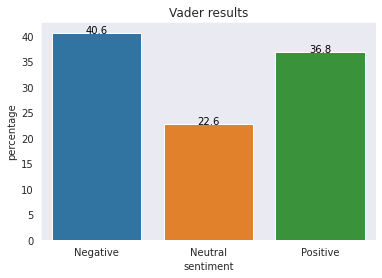

In [ ]:
ax = sns.barplot(x="sentiment", y="percentage", data=tb_sentiment_df)
ax.set_title('Vader results')

for index, row in tb_sentiment_df.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

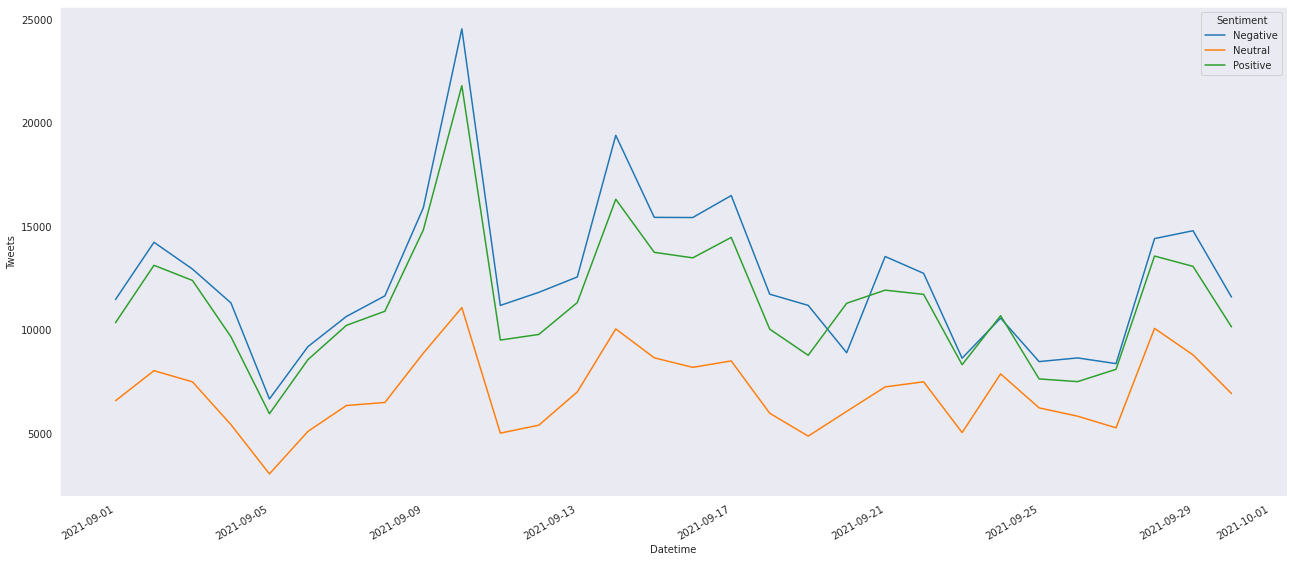

In [ ]:
df["Datetime"] = pd.to_datetime(df.Datetime) 
timeline = df.resample('D', on='Datetime')["Sentiment"].value_counts().unstack(1)
timeline.reset_index(inplace=True)
timeline = timeline.melt("Datetime", var_name='Sentiment',  value_name='Tweets')

plt.figure(figsize=(22,10))
ax = sns.lineplot(x="Datetime", y="Tweets", hue="Sentiment", data=timeline)
ax.figure.autofmt_xdate()

**Top 10 most Negative Tweets**

In [ ]:
pd.set_option('display.max_colwidth', 400)
df.sort_values(by='VComp', ascending=True)[['Text', 'VComp', 'Username']].reset_index(drop=True).head(n=10)

,Text,VComp,Username
0,This is just a rant:\nFUCK Joe Biden\nFUCK aoc\nFUCK Covid \nFUCK vaccines\nFUCK Kardashian\nFUCK Pelosi\nFUCK Harris\nFUCK Obama (Mike included)\nFUCK Clinton\nFUCK Bush (🤭)\nFUCK masks\nFUCK liberals\nFUCK democrats\nFUCK socialists\nFUCK communism\nFUCK Sanders\nFUCK NWO\nFUCK mRNA\n\nTy &amp; sry,-0.9963,IranianSadieUSA
1,WAR CRIMINAL! WAR CRIMINAL! WAR CRIMINAL! WAR CRIMINAL! WAR CRIMINAL LIKE ALL OTHER MASS MURDERERS PROMOTING THAT CRIME =Chris Whitty Approves Covid-19 Vaccine For Kids Despite a Mountain of Evidence They Are Killing Children https://t.co/mEKOya9JIV,-0.9923,Rakiko_Hime
2,@SharkawyMD So very sorry Dr. The C word is terrible. Both Cs are terrible but in my opinion cancer is much worse because at least with Covid there is a vaccine. I’ve too lost close family to cancer and sadly cancer patients are being impacted by Covid beds. It’s a sad time.,-0.9911,My_FairLady
3,Repulsives are great at waging wars:\nWar on Immigrants \nWar on healthcare\nWar on weapons control\nWar on masks\nWar on COVID vaccines\nWar on voting rights\nWar on women's right to choose.\n\nIt's time we rise up &amp; make our voices heard.\n\nWe're mad as hell &amp; won't take it anymore.,-0.9902,MarTheResister
4,"@Midnightszone @rosemcgowan @NICKIMINAJ But they can also cause all those things. They can literally kill you. They have literally killed 1,000s upon 1,000s. Thats what was reported. A lot of vaccine death was just reported as more covid death... Also where did flu death go? (added to ""covid"" as well, to ramp up fears)",-0.9901,koolaid_joe
5,@ZiikZiiii Covid Priest work around account metric\npandemic ⚖️ crisis ⚖️ ill health ⚖️ death\npandemic ⚖️ masks ⚖️ ill health ⚖️ death\npandemic ⚖️ vaccine ⚖️ ill health ⚖️ death\npandemic ⚖️ economy ⚖️ ill health ⚖️ death\npandemic ⚖️ HAZMAT ⚖️ ill health ⚖️ death\nAll measures in metric 🥬,-0.9896,Dependent2020
6,"@jordanbpeterson It is fear that will kill you. Fear. Fear and fear. Fear of Covid. Fear of vaccine. Fear of unvaccinated. Fear is also turning into hatred. Hatred for the unmasked, unvaccinated, and for those who want truth.",-0.9892,candel_aria
7,"I should be enjoying my early 20s but instead i get a ton of shit. Fuck covid, I’m over this shit. If people don’t wanna get vaccinated then fine you can go die and maybe learn the lesson the hard way. I’m over these anti mask anti vaccine shit heads. Fuck you all",-0.9891,RosyCutiee
8,WOMEN OF AMERICA\n\nFIGHT\n\nFIGHT LIKE HELL\n\nDO NOT ACCEPT THE MISOGYNISTIC VILE EVIL OVERTAKING OF OUR NATION\n\nG Q P WANTS YOU TO DIE OF COVID UNLESS YOU ARE PREGNANT THEN THEY WANT THE BABY TO KILL IT LATER IN SCHOOL WITHOUT A MASK OR VACCINE THEN KILL YOU WITH MISOGYNY\n\nITS WAR https://t.co/S9XoGij74D,-0.9890,FPPunohuReport
9,WOMEN OF AMERICA 2\n\nFIGHT\n\nFIGHT LIKE HELL\n\nDO NOT ACCEPT THE MISOGYNISTIC VILE EVIL OVERTAKING OF OUR NATION\n\nG Q P WANTS YOU TO DIE OF COVID UNLESS YOU ARE PREGNANT THEN THEY WANT THE BABY TO KILL IT LATER IN SCHOOL WITHOUT A MASK OR VACCINE THEN KILL YOU WITH MISOGYNY\n\nITS WAR https://t.co/LRY4evny1q,-0.9890,FPPunohuReport


**Top 10 most Positive Tweets**

In [ ]:
df.sort_values(by='VComp', ascending=False)[['Text', 'VComp', 'Username']].reset_index(drop=True).head(n=10)

,Text,VComp,Username
0,@PlacidoNatanael @amityblightoff @DanaTerrace wish right now\nwish right now\nwish right now\nwish right now\nwish right now\nwish right now\nwish right now\n👁 it never 👄 ever ends 👁\nwish right now\nwish right now\nwish right now\nwish right now\nwish right now\nwish right now\nwish right now\nwish right now\nwish right now,0.9900,MR_C_HANNAH
1,"@JudgeClayJ @NCTTRAC Judge you are my hero. Smart and love freedom. Freedom to vote, freedom to get the Covid vaccine (like Measles etc) freedom to not stop abortion. Let’s stop male fertility first. Let them be responsible for that they do with one part of their body. Or take their sperm away😉",0.9881,Blistful
2,"He's right, you could still get covid if you had the vaccine. But the best vaccines are ~90% effective -- about what Giannis shot from the free throw line in Game Six when the Bucks won the Finals. So, pretty good! https://t.co/rVVSLC3Qjn",0.9866,DanRShafer
3,I got vaccinated because I love my freedom. Not only can I now go places but I have the bonus of feeling reassured that I am less likely to infect other people. Win win #Covid_19 #COVIDIOT #VaccinePassports #vaccine #Vaccination #freedom,0.9866,TerryMa62957619
4,"A #quoteoftheday that is both true &amp; odd. Sniffing 😿 makes me think of pets but it is true that looking around to find the helpers, heroes &amp; good may bring joy. Happy Friday \n\nIf you haven’t got #CovidVaccine yet, talk to your healthcare worker &amp; bring some joy to others 💉 https://t.co/VBRq2dkoCZ",0.9865,jendlake
5,"@EricaCait But, by her logic, God also created Covid. Good job, God. Sounds very business-like: God creates virus; God creates vaccine; God makes billions on said vaccine. But really, God created life, and we have choices as free living spirits.",0.9865,pkeating3315
6,From october new semester start in universities but I think classes will was online again because covid is very very intense and I do not know which day I will get vaccine in october but I am super super super super happy I can get vaccine in october 🤗🤗🤗🤗🤗🤗🤗🤗 @perthppe,0.9858,20__perth
7,"getting £1500 would actually b the 1st miracle , but 2nd miracle is somehow getting a second covid vaccine dose rlly fast,\n3rd miracle is US actually opening borders to UK in november \n4th miracle is getting a ticket LMAO . but i’d be happy to jus camp outside the venue",0.9854,jeonichka
8,@robert_zubrin @brad_polumbo @Heritage Agreed you are 100% correct but know that huge Israeli Study just proved that natural immunity like mine ( I've had Covid-19 and the Covid Delta variant) is 13 times as strong as the best covid vaccine and it's still holding strong it did not drop off a cliff like they said,0.9851,Lana_Billy_Rey
9,@EL44766671 @NC_Governor At least they’ve had extensive research and years of trials before being approved by the FDA! Unlike the COVID vaccines!! But thank god we live in a Free country and you can do what you think is best for you and I can do what I think is best for me! God bless!!,0.9851,weh273


In [ ]:
pip install nrclex

     |████████████████████████████████| 396 kB 5.2 MB/s 
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43328 sha256=353c7e9d53a1bd44763bd9633a5b39a1f174afdd5ebdce59f4221510a85cd825
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built nrclex


In [ ]:
from nrclex import NRCLex
#nrclex outputs a score for all 9 emotions, but we only want the emotion with the highest score (usually the first output)
emotion = []
for i in range(len(df)):
    emotions = NRCLex(df['Clean Text'][i])
    emotion.append(emotions.top_emotions[0][0])
df['Emotion'] = emotion


In [ ]:
df["Emotion"].value_counts()

positive        496427
fear            177300
negative        104455
trust            93271
anger            23436
anticipation     13003
surprise         10656
sadness           2413
disgust            248
joy                 32
Name: Emotion, dtype: int64

In [ ]:
def get_value_counts_emotion(col_name):
    count = pd.DataFrame(df[col_name].value_counts())
    percentage = pd.DataFrame(df[col_name].value_counts(normalize=True).mul(100))
    value_counts_df = pd.concat([count, percentage], axis = 1)
    value_counts_df = value_counts_df.reset_index()
    value_counts_df.columns = ['emotion', 'counts', 'percentage']
    value_counts_df.sort_values('emotion', inplace = True)
    value_counts_df['percentage'] = value_counts_df['percentage'].apply(lambda x: round(x,2))
    value_counts_df = value_counts_df.reset_index(drop = True)
    return value_counts_df
emotion_df = get_value_counts_emotion('Emotion').sort_values(by='counts',ascending=False).reset_index()
del emotion_df["index"]

emotion_df

,emotion,counts,percentage
0,positive,496427,53.89
1,fear,177300,19.25
2,negative,104455,11.34
3,trust,93271,10.12
4,anger,23436,2.54
5,anticipation,13003,1.41
6,surprise,10656,1.16
7,sadness,2413,0.26
8,disgust,248,0.03
9,joy,32,0.00


Text(0.5, 1.0, 'Emotion Analysis- December Data')

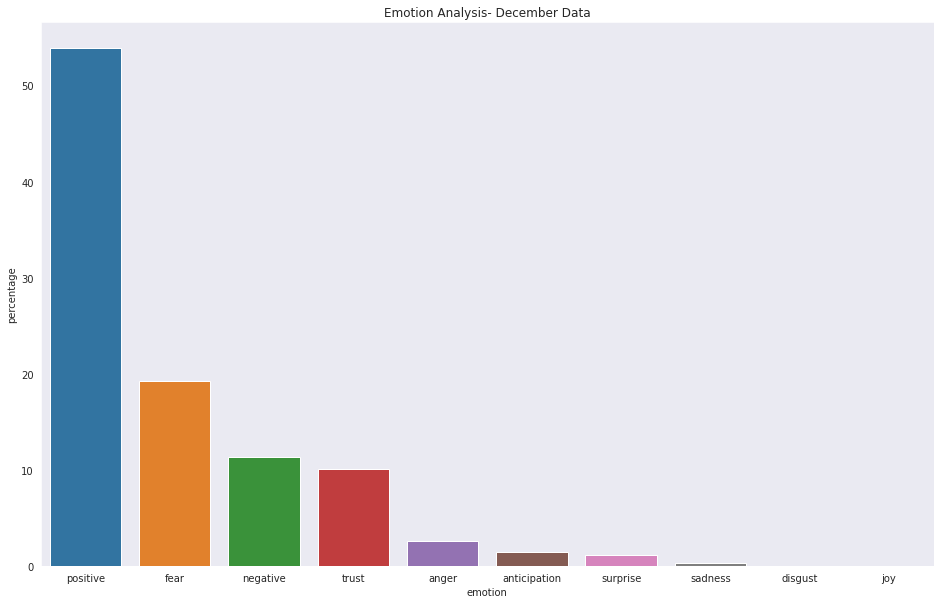

In [ ]:
# Plotting percentage of sentiments
plt.figure(figsize=(16,10))
ax = sns.barplot(x="emotion", y="percentage", data=emotion_df)
ax.set_title('Emotion Analysis- September Data')


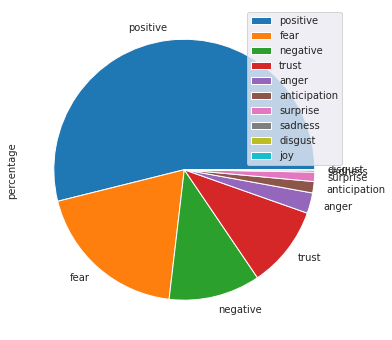

In [ ]:
plot = emotion_df.set_index('emotion').plot.pie(y='percentage', figsize=(10, 6))